In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


import torchvision
import torchvision.transforms as transforms

sys.path.append('../')
from models.vit import *

/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [3]:
epochs = 90
batch_size = 64
momentum = 0.9
lr = 0.00005
weight_decay = 1e-4
img_size = 32
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_workers = os.cpu_count()
saved = '../saved/cifar_net_32.pth'

In [4]:
train_transforms = transforms.Compose([
                    transforms.ColorJitter(0.1,0.1,0.1,0.1),
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0), ratio=(0.75, 1.25)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [5]:
train_dataset = torchvision.datasets.CIFAR10('../dataset', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10('../dataset', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
images, targets = next(iter(train_loader))
images.shape, targets

(torch.Size([64, 3, 32, 32]),
 tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
         2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
         2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7]))

In [8]:
model_args = dict(img_size=img_size, 
                  patch_size=8, 
                  embed_dim=192, 
                  depth=12, 
                  num_heads=2, 
                  checkpoint='', 
                  qk_norm=True, 
                  v_norm=True, 
                  patch_stride=4)
model =  vit_small_patch8_32(**model_args)

In [9]:
out = model(images)
out.shape

torch.Size([64, 10])

In [10]:
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


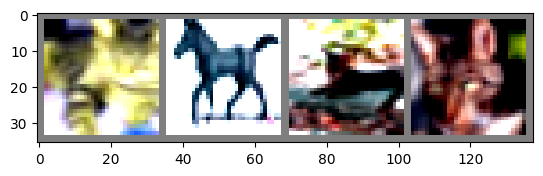

In [13]:
imshow(torchvision.utils.make_grid(images[:4]))

In [14]:

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, )
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=5, 
#                                         step_size_down=None, mode='exp_range', gamma=0.995)
from utils.scheduler import CosineAnnealingWarmUpRestarts
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, T_mult=1, eta_max=0.1,  T_up=6, gamma=0.25)

model = model.to(device)

In [15]:
from utils.train import get_acc

In [16]:
best_acc = 0.
val_acc_list = []
for epoch in (range(epochs)):
    running_loss = []
    model.train()
    for i, data in (enumerate(train_loader)):
        images, targets = data
        images, targets = images.to(device), targets.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    test_acc = get_acc(test_loader, model, device)
    val_acc_list.append(test_acc)
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), saved)

    lr = optimizer.param_groups[0]['lr']
    print(f'{epoch + 1} loss: {sum(running_loss)/len(running_loss):.3f} acc: {test_acc:.2f} lr: {lr:.5f}')
    if scheduler :
        scheduler.step()


1 loss: 1.999 acc: 34.39 lr: 0.00005
2 loss: 1.687 acc: 46.41 lr: 0.01671
3 loss: 1.479 acc: 48.51 lr: 0.03337
4 loss: 1.386 acc: 54.08 lr: 0.05003
5 loss: 1.323 acc: 53.53 lr: 0.06668
6 loss: 1.259 acc: 57.00 lr: 0.08334
7 loss: 1.211 acc: 58.53 lr: 0.10000
8 loss: 1.150 acc: 61.86 lr: 0.09957
9 loss: 1.089 acc: 62.28 lr: 0.09830
10 loss: 1.031 acc: 65.67 lr: 0.09620
11 loss: 0.984 acc: 64.03 lr: 0.09330
12 loss: 0.940 acc: 67.79 lr: 0.08967
13 loss: 0.893 acc: 68.81 lr: 0.08536
14 loss: 0.853 acc: 69.69 lr: 0.08045
15 loss: 0.819 acc: 70.47 lr: 0.07501
16 loss: 0.787 acc: 70.91 lr: 0.06915
17 loss: 0.749 acc: 73.88 lr: 0.06296
18 loss: 0.712 acc: 73.25 lr: 0.05655
19 loss: 0.684 acc: 74.04 lr: 0.05003
20 loss: 0.653 acc: 76.63 lr: 0.04350
21 loss: 0.618 acc: 76.59 lr: 0.03709
22 loss: 0.586 acc: 77.93 lr: 0.03090
23 loss: 0.560 acc: 78.48 lr: 0.02504
24 loss: 0.533 acc: 78.68 lr: 0.01960
25 loss: 0.505 acc: 79.59 lr: 0.01469
26 loss: 0.486 acc: 80.08 lr: 0.01038
27 loss: 0.458 acc: 8

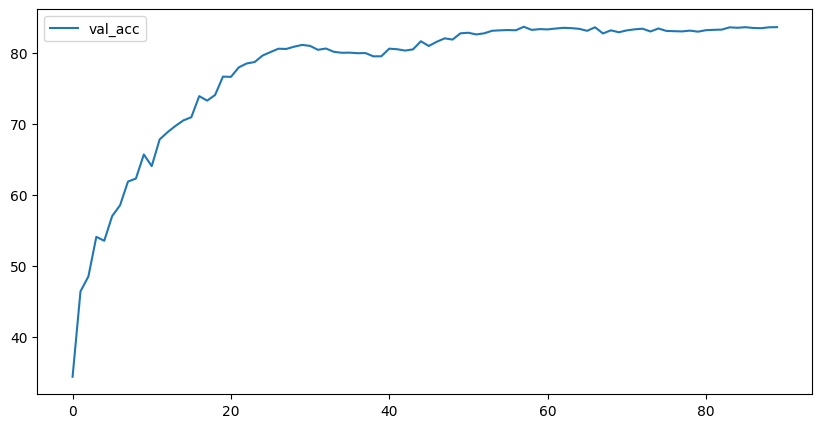

In [17]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,5]
plt.plot(val_acc_list, label='val_acc')
plt.legend()


In [18]:
from utils.train import get_all_preds
test_preds = get_all_preds(model.to('cpu'), test_loader)
actual_labels = torch.Tensor(test_dataset.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_dataset))

total correct: 8359
accuracy: 0.8359


Confusion matrix, without normalization
[[848  15  33  11  10   5   2  10  43  23]
 [  6 915   2   4   0   0   3   1  12  57]
 [ 35   3 792  35  37  21  44  23   5   5]
 [ 23  14  42 667  46 108  55  24  10  11]
 [ 15   1  38  24 816  17  40  38   8   3]
 [  6   8  22 114  36 740  25  39   5   5]
 [  9   5  17  25  17  12 905   1   4   5]
 [ 14   1  15  14  22  32   5 887   3   7]
 [ 52  10   5   7   6   1   2   0 898  19]
 [ 22  51   1   9   0   0   5   7  14 891]]


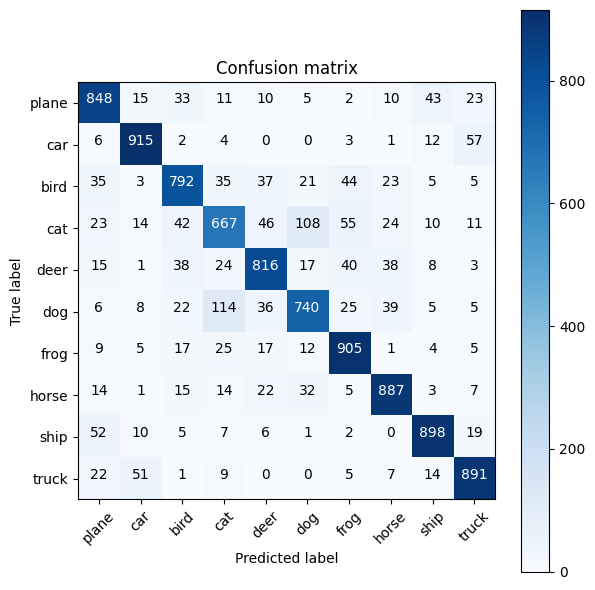

In [19]:
from utils.visualize import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes)